In [37]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt

In [38]:
config = configparser.ConfigParser()
config.read('db_config.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)

In [39]:
def get_data(query, columns = None):
    """Query in SQL STRING
    Columns = List of strings representing the columns for the df"""
    mycursor = sql_conn.cursor()
    mycursor.execute(query)
    result = mycursor.fetchall()
    data_list = list(result)
    if columns == None:
        df = pd.DataFrame(data_list)
        return df
    else:
        df = pd.DataFrame(data_list, columns= columns)
        return df

In [40]:
#Find all events where opioid dependence was diagnosed (has to appear 2+ times)

query_diagnosis_columns = """SELECT *
FROM syscolumns
WHERE id=OBJECT_ID('CDW_NEW.deid_uf.DiagnosisEventFact') """
diagnosis_columns = get_data(query_diagnosis_columns)[0].to_list()
query_opioid = """
    SELECT * 
    FROM CDW_NEW.deid_uf.DiagnosisEventFact
    WHERE DiagnosisName LIKE '%opioid%'
    AND DiagnosisName LIKE '%dependence%'
    AND DiagnosisName NOT LIKE '%excluding opioid%'
"""

opioid_diagnosis = get_data(query_opioid, diagnosis_columns)

#Screen for recurrence of minimum 2

opioid_diagnosis = opioid_diagnosis.groupby('PatientDurableKey').filter(lambda x: len(x) >= 2)
opioid_diagnosis.head()

,DeidLds,PatientDurableKey,DiagnosisEventKey,DiagnosisKey,DiagnosisName,PatientKey,AgeKey,AgeKeyValue,EncounterKey,DepartmentKey,...,DocumentedByProviderType,DocumentedByProviderPrimarySpecialty,DocumentedByProviderDurableKey,Type,Status,PresentOnAdmission,HospitalDiagnosis,EmergencyDepartmentDiagnosis,Chronic,Count
0,deid_uf,DB602DEDB6FA2E,D07B1FEAE545ED,103147,"Opioid type dependence, in remission",D29A68B1082267,9927004.0,NaN,DAFE0DBBC7A702,269,...,Physician,,240926,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
1,deid_uf,D2B4C2AFDD5D14,DDA99CE7A9CBDA,890985,Opioid dependence on agonist therapy (CMS code),D659F6E000898D,8571004.0,NaN,D6582EDCAD0B40,808,...,Physician,Obstetrics and Gynecology,228096,Problem List,Active,*Unspecified,0.0,NaN,0.0,1
2,deid_uf,D2B4C2AFDD5D14,D70C02DE4061D4,890985,Opioid dependence on agonist therapy (CMS code),D659F6E000898D,8571004.0,NaN,D6582EDCAD0B40,808,...,Physician,Obstetrics and Gynecology,228096,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
3,deid_uf,D4EFF6435B4E12,DC55E97C0455EA,666470,"Opioid type dependence, unspecified",D9C1CB3C976A8D,11194004.0,NaN,DF87E4E27F00BF,808,...,Physician,Obstetrics and Gynecology,228096,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
4,deid_uf,D2B4C2AFDD5D14,DDA4189EB19D2B,890985,Opioid dependence on agonist therapy (CMS code),D659F6E000898D,8613004.0,NaN,DB1903990A4D5D,808,...,Physician,Obstetrics and Gynecology,228096,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47358,deid_uf,DA351C11F4A333,D0102AC314C1EA,666470,"Opioid type dependence, unspecified",DCAE22D99DA883,19305004.0,NaN,D3F275D7E6323F,225,...,Physician,Internal Medicine,183265,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
47359,deid_uf,D22DD009429681,DE201BD90ACD96,247835,Opioid dependence (CMS code),DBA5A47E5D14A2,12281004.0,671.0,D8AB365CC2C0E9,3427,...,Physician,Internal Medicine,233017,Hospital Problem,Active,Unknown,1.0,NaN,0.0,1
47360,deid_uf,DCC22B303BDB3F,D143B1F8910394,630317,Opioid dependence with withdrawal (CMS code),D20A8EC15ABC9F,11269004.0,NaN,DC3D6F69EE511F,17293,...,Physician,Hospital Medicine,231701,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
47361,deid_uf,D54C8EC5A11771,D76E6E9E3BCC0A,351697,Uncomplicated opioid dependence (CMS code),DBA74969D4B312,13768004.0,NaN,D0649A3E12F46D,179,...,Scribe,,512838,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1


In [42]:
type(opioid_diagnosis["PatientDurableKey"])

pandas.core.series.Series

In [43]:
#Find all events where opioids were prescribed to patients— limited to oxycontin and oxycodone

# dependent_record_keys = opioid_diagnosis["PatientDurableKey"].tolist()
# dependent_record_keys_str = ', '.join([str(key) for key in dependent_record_keys])

query_med_columns = """SELECT *
FROM syscolumns
WHERE id=OBJECT_ID('CDW_NEW.deid_uf.MedicationOrderFact') """
med_columns = get_data(query_med_columns)[0].to_list()
query_opioid_presc = f"""
SELECT * 
FROM CDW_NEW.deid_uf.MedicationOrderFact
WHERE (MedicationName LIKE '%oxycontin%'
OR MedicationName LIKE '%oxycodone%')
"""
opioid_prescribed = get_data(query_opioid_presc, med_columns)
opioid_prescribed.head()

,DeidLds,PatientDurableKey,MedicationOrderKey,PatientKey,EncounterKey,DepartmentKey,BedName,DepartmentName,DepartmentSpecialty,PharmacyKey,...,ReorderedFromPrescription,Verbal,RequiresCosign,Cosigned,VerbalSigned,Protocol,HighPriority,Prn,Count,SupervisedByProviderDurableKey
0,deid_uf,D7FB40E1815E55,DC8A7CFC1C4FC6,D85E6E3E0299D2,DC1398D1099B3A,17425,*Not Applicable,RAD IR PCMB 2,Interventional Radiology,-2,...,0.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0,1,-1
1,deid_uf,D734CCE8B11FFC,D6D15AB0D88A00,D99181B2EBAFCF,DBF0BB48382BA9,22,*Not Applicable,12L MUSCULOSKELETAL,*Unspecified,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1,-1
2,deid_uf,D734CCE8B11FFC,D83908A863B4EC,D99181B2EBAFCF,DBF0BB48382BA9,22,*Not Applicable,12L MUSCULOSKELETAL,*Unspecified,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1,-1
3,deid_uf,DAE1A2E2EFC7C3,DA146254AF5871,DA57C0AD4CD58B,DFEF081572F155,240,*Not Applicable,TRANSFUSION PARN,Infusion and Transfusion,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1,-1
4,deid_uf,DAF6243BFEC85B,D40E920D3C1E47,DCE0E28819F66F,D25C75C4935D5D,43,*Not Applicable,EMERGENCY DEPT PARN,Emergency Medicine,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313980,deid_uf,DD4084D18EB42B,D60F15017DB99A,D16A42CFF5FCAF,DC1E0199185725,71,*Not Applicable,HEMODIALYSIS PARN,Dialysis,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1,-1
1313981,deid_uf,DB01F973DF8826,D0EB1767C6D3C4,DA3732C158C161,D9F00EDE7978C9,28,*Not Applicable,L14 MEDSURG-ONC/BMT B,*Unspecified,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1,-1
1313982,deid_uf,DD3E1D2D7E07B0,D1B87DC215E3AB,D936C571E2C111,D23CA6867F15A2,240,*Not Applicable,TRANSFUSION PARN,Infusion and Transfusion,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1,-1
1313983,deid_uf,D23027576D834F,DB56F389BFC07D,D25319CB99B0E9,D8B1DEA0D6782E,2545,*Not Applicable,APHERESIS PARN,Hematology and Oncology,-2,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0,1,-1


In [44]:
#Merge the prescribed and diagnosis dataframes
opioid_composite = pd.merge(opioid_diagnosis, opioid_prescribed, on="PatientDurableKey", suffixes=('_diagnosis', '_prescribed'))

# Filter where the startDateKey from opioid_diagnosis is smaller than the startDateKey from opioid_prescribed
filtered_opioid_composite = opioid_composite[(opioid_composite['StartDateKey_diagnosis'] < opioid_composite['StartDateKey_prescribed']) & (opioid_composite['StartDateKey_diagnosis'] > 0)]

In [45]:
filtered_opioid_composite[["DiagnosisName", "StartDateKey_diagnosis", "StartDateKey_prescribed"]]

,DiagnosisName,StartDateKey_diagnosis,StartDateKey_prescribed
1,Opioid dependence (CMS code),20000411,20201229
2,Opioid dependence (CMS code),20000411,20201229
3,Opioid dependence (CMS code),20000411,20201229
4,"Opioid use disorder, severe, dependence (CMS c...",20200529,20200929
5,"Opioid use disorder, severe, dependence (CMS c...",20200529,20230414
...,...,...,...
999678,Opioid type dependence (CMS code),20170710,20180903
999682,Opioid type dependence (CMS code),20170710,20180831
999686,Opioid type dependence (CMS code),20170710,20170721
999687,Opioid type dependence (CMS code),20170710,20180805


In [46]:
# How many unique patients have been prescribed opioids AFTER being diagnosed with opioid dependency?
filtered_opioid_composite['PatientDurableKey'].nunique()

3026

## Doing the same thing with Alcohol Dependence (Alc Dependence --> Opioid Prescription)

In [48]:
#Find all events where alcohol dependence was diagnosed

query_alcohol = """SELECT * FROM CDW_NEW.deid_uf.DiagnosisEventFact
WHERE DiagnosisName LIKE '%alcohol dependence%'
"""
# query_ms= """SELECT * FROM CDW_NEW.deid_uf.DiagnosisEventFact
# WHERE DiagnosisName LIKE '%multiple sclerosis%' """
alcohol_diagnosis = get_data(query_alcohol, diagnosis_columns)

#Screen for recurrence of minimum 2

alcohol_diagnosis = alcohol_diagnosis.groupby('PatientDurableKey').filter(lambda x: len(x) >= 2)
alcohol_diagnosis

,DeidLds,PatientDurableKey,DiagnosisEventKey,DiagnosisKey,DiagnosisName,PatientKey,AgeKey,AgeKeyValue,EncounterKey,DepartmentKey,...,DocumentedByProviderType,DocumentedByProviderPrimarySpecialty,DocumentedByProviderDurableKey,Type,Status,PresentOnAdmission,HospitalDiagnosis,EmergencyDepartmentDiagnosis,Chronic,Count
0,deid_uf,D93A2350DE5365,D3A95B4170A906,1152295,Alcohol dependence with unspecified alcohol-in...,D71B78D00DCA42,14491004.0,450.0,DE5B2B518A3F88,178,...,Physician,Hepatology,968879,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
1,deid_uf,D588ED98DFC94D,DF07C89D4E73EB,1152295,Alcohol dependence with unspecified alcohol-in...,D3C357F6219020,28137004.0,NaN,DFD45B75F01A36,831,...,Physician,Internal Medicine,196097,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
2,deid_uf,D588ED98DFC94D,D44B80FF4451E6,1152295,Alcohol dependence with unspecified alcohol-in...,D3C357F6219020,28023004.0,NaN,D7E2108598D7EE,831,...,Physician,Family Medicine,151211,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
3,deid_uf,D6EF9DC5B3421D,D7DE0D9A0013E7,491111,"Alcohol dependence, uncomplicated (CMS code)",D092447008A4BB,NaN,NaN,D6CE25DCB78153,23898,...,Social Worker,Psychology,238191,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
4,deid_uf,D346A970BA68A9,D6E092DC8F57DF,325545,"Alcohol dependence, in remission (CMS code)",D0152A95E3FF20,NaN,NaN,D9D2259AC74EDC,1010,...,Nurse Practitioner,General Surgery,117182,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108006,deid_uf,DAF2684AE584E3,D5D004944D07BD,797568,Alcohol dependence in remission (CMS code),D39E5C77500257,21459004.0,NaN,D5FD015B7CC099,178,...,Resident,UCSF,233701,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
108007,deid_uf,D50EC3C6E528EB,DD67E5F3940CD2,491111,"Alcohol dependence, uncomplicated (CMS code)",D356DB521CF367,NaN,NaN,DF71B7F6D8E650,-2,...,*Not Applicable,*Not Applicable,-2,Billing Diagnosis,Active,*Unspecified,NaN,NaN,NaN,1
108008,deid_uf,D7E653D28D1BE7,DC00A4C2747EF9,390132,"Alcohol dependence with withdrawal, uncomplica...",D10CF7A6AFDA04,20974004.0,NaN,-2,-2,...,*Not Applicable,*Not Applicable,-2,Outgoing Claim Diagnosis,Active,Yes,0.0,0.0,NaN,1
108009,deid_uf,D79E42E06BD506,D57B4C9E57B240,390132,"Alcohol dependence with withdrawal, uncomplica...",DD9260F6D28B81,16679004.0,NaN,-2,-2,...,*Not Applicable,*Not Applicable,-2,Outgoing Claim Diagnosis,Active,Yes,0.0,0.0,NaN,1


In [49]:
#Merge the prescribed and diagnosis dataframes
alcohol_composite = pd.merge(alcohol_diagnosis, opioid_prescribed, on="PatientDurableKey", suffixes=('_diagnosis', '_prescribed'))

# Filter where the startDateKey from opioid_diagnosis is smaller than the startDateKey from opioid_prescribed
filtered_alcohol_composite = alcohol_composite[(alcohol_composite['StartDateKey_diagnosis'] < alcohol_composite['StartDateKey_prescribed']) & (alcohol_composite['StartDateKey_diagnosis'] > 0)]

In [50]:
filtered_alcohol_composite[["DiagnosisName", "StartDateKey_diagnosis", "StartDateKey_prescribed"]]

,DiagnosisName,StartDateKey_diagnosis,StartDateKey_prescribed
54,Alcohol dependence with unspecified alcohol-in...,20210208,20210601
81,"Alcohol dependence with withdrawal, uncomplica...",20160114,20160302
131,"Alcohol dependence with withdrawal, uncomplica...",20160114,20160122
143,"Alcohol dependence with withdrawal, uncomplica...",20160114,20160126
148,"Alcohol dependence with withdrawal, uncomplica...",20160114,20160118
...,...,...,...
665463,Uncomplicated alcohol dependence (CMS code),20140605,20180221
665464,Uncomplicated alcohol dependence (CMS code),20140605,20161125
665465,Uncomplicated alcohol dependence (CMS code),20140605,20160713
665466,Uncomplicated alcohol dependence (CMS code),20140605,20170805


In [51]:
# How many unique patients have been prescribed opioids AFTER being diagnosed with alcohol dependency?
filtered_alcohol_composite['PatientDurableKey'].nunique()

3240

## Sex break down of Each Cohort

In [52]:
query_patinfo_columns = """SELECT *
FROM syscolumns
WHERE id=OBJECT_ID('CDW_NEW.deid_uf.PatDurableDim') """
patinfo_columns = get_data(query_patinfo_columns)[0].to_list()

# Create sex distribution chart
def sex_dist(sex_table, title):
    unique_key = sex_table.groupby('PatientDurableKey').first().reset_index()
    sex_counts = unique_key["Sex"].value_counts()
    sex_counts.plot(kind = 'bar')
    plt.title(title)
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()
    print(sex_counts)

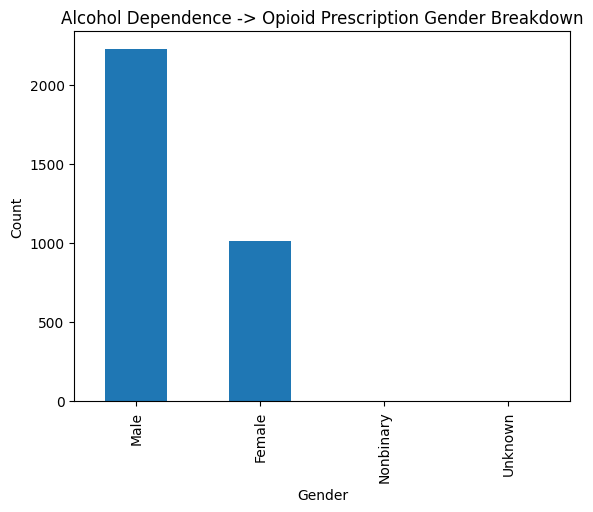

Sex
Male         2225
Female       1013
Nonbinary       1
Unknown         1
Name: count, dtype: int64


In [53]:
#Convert the relevant patient IDs to string— Alcohol
alc_keys_list = tuple(filtered_alcohol_composite['PatientDurableKey'].unique())

#Grab relevant PatientDurableKeys

query_alc_patinfo = f"""
    SELECT * 
    FROM CDW_NEW.deid_uf.PatDurableDim
    WHERE PatientDurableKey IN {alc_keys_list}
"""
alc_patinfo = get_data(query_alc_patinfo, patinfo_columns)

#Merge the tables together
filtered_alcohol_composite = pd.merge(filtered_alcohol_composite, alc_patinfo, on="PatientDurableKey", suffixes=('', '_patinfo'))

sex_dist(filtered_alcohol_composite[["PatientDurableKey", "Sex"]], "Alcohol Dependence -> Opioid Prescription Gender Breakdown")

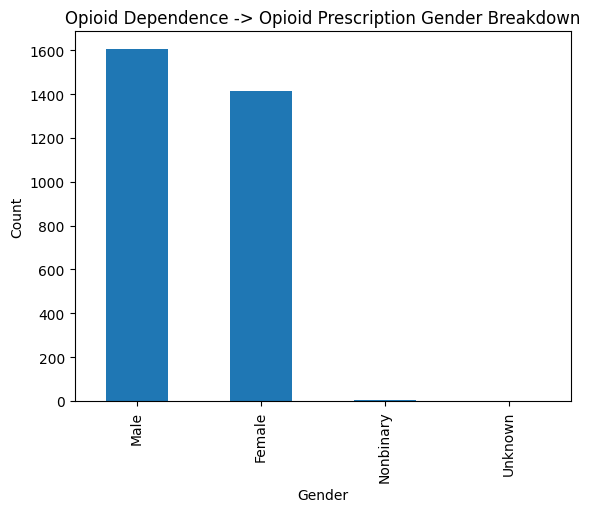

Sex
Male         1606
Female       1415
Nonbinary       3
Unknown         2
Name: count, dtype: int64


In [54]:
#Convert the relevant patient IDs to string— Opioid
opioid_keys_list = tuple(filtered_opioid_composite['PatientDurableKey'].unique())

#Grab relevant PatientDurableKeys

query_opioid_patinfo = f"""
    SELECT * 
    FROM CDW_NEW.deid_uf.PatDurableDim
    WHERE PatientDurableKey IN {opioid_keys_list}
"""
opioid_patinfo = get_data(query_opioid_patinfo, patinfo_columns)

#Merge the tables together
filtered_opioid_composite = pd.merge(filtered_opioid_composite, opioid_patinfo, on="PatientDurableKey", suffixes=('', '_patinfo'))

sex_dist(filtered_opioid_composite[["PatientDurableKey", "Sex"]], "Opioid Dependence -> Opioid Prescription Gender Breakdown")

# How many prescribed opioids with NO previous dependence

In [15]:
#Find all events where no dependence was diagnosed (Is this the right way to do it? Seems off, takes wayy too long to run...)

query_control = """SELECT * FROM CDW_NEW.deid_uf.DiagnosisEventFact
WHERE DiagnosisName NOT LIKE '%dependence%'
"""
# query_ms= """SELECT * FROM CDW_NEW.deid_uf.DiagnosisEventFact
# WHERE DiagnosisName LIKE '%multiple sclerosis%' """
control_diagnosis = get_data(query_control, diagnosis_columns)
control_diagnosis

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f741c148910>>
Traceback (most recent call last):
  File "/pool0/home/sanjay.r/anaconda3/envs/sergio_rotation/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
